# Experiments with K-Means Clustering and PCA 
 - Dataset: [SVNH Dataset](http://ufldl.stanford.edu/housenumbers/) (Format 2)

#### a) Perform k means clustering with k=10 on the raw data and on data obtained after PCA dimensionality reduction for dimension as found in question 1 (a) and for dimension 10 as in question 1 (b). You may use only training data of SVHN to perform this. Do you observe images from the same class to be clustered together ? For each cluster, provide the image closest to the centroid.


In [24]:
from sklearn.cluster import KMeans
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed
np.random.seed(42)

### Data Preparation

In [20]:
train_data = './data/train_32x32.mat'
test_data = './data/test_32x32.mat'

train = sio.loadmat(train_data)
test = sio.loadmat(test_data)

X_train, y_train = train['X'], train['y']
X_test, y_test = test['X'], test['y']

print(f'Before reshaping: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Before reshaping: X_test: {X_test.shape}, y_test: {y_test.shape}')

# Reshape the data to NxHxWxC
X_train = X_train.transpose((3, 0, 1, 2))
X_test = X_test.transpose((3, 0, 1, 2))
# Make y_test and y_train into a 1D array
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Change all the 10s in the labels to 0s
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

print(f'After reshaping: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'After reshaping: X_test: {X_test.shape}, y_test: {y_test.shape}')

Before reshaping: X_train: (32, 32, 3, 73257), y_train: (73257, 1)
Before reshaping: X_test: (32, 32, 3, 26032), y_test: (26032, 1)
After reshaping: X_train: (73257, 32, 32, 3), y_train: (73257,)
After reshaping: X_test: (26032, 32, 32, 3), y_test: (26032,)


Image shape: (32, 32, 3), Label: 9


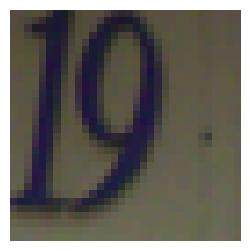

In [26]:
idx = 1
image, label = X_train[idx], y_train[idx]
print(f'Image shape: {image.shape}, Label: {label}')

# Visualise image with matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis('off')
plt.show()

In [27]:
# Pick 2500 samples from each class
print(f'min: {np.min(y_train)}, max: {np.max(y_train)}')
X_samples, y_samples = [], []
for i in range(10):
    indices = np.where(y_train == i)[0]
    random_indices = np.random.choice(indices, 2500, replace=False)
    X_samples.append(X_train[random_indices])
    y_samples.append(y_train[random_indices])

X_train, y_train = np.concatenate(X_samples), np.concatenate(y_samples)
print(f'After sampling: train_X: {X_train.shape}, train_y: {y_train.shape}')

min: 0, max: 9
After sampling: train_X: (25000, 32, 32, 3), train_y: (25000,)


In [28]:
def find_centroids(
    X:np.ndarray,
    n_clusters:int=10,
    scale:bool=False,
    verbose:bool=False
    ):
    """ Finds the centroids using KMeans clustering
        params:
            X: The data to cluster (NxD)
            n_clusters: The number of clusters to use
            scale: Whether to scale the data or not
            verbose: Set to true to print iterations
        returns:
            The centroids of the clusters, labels, indices closest to each centroid, sum squared error
    """

    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, max_iter=100, random_state=42, verbose=verbose)
    scaler = StandardScaler()

    if scale:
        X = scaler.fit_transform(X)
    kmeans.fit(X)
    
    # Find point closest to each centroid
    closest_points = np.zeros(n_clusters)
    for i in range(n_clusters):
        closest_points[i] = np.argmin(np.sum((X - kmeans.cluster_centers_[i])**2, axis=1))

    sum_squared_error = kmeans.inertia_

    centroids = scaler.inverse_transform(kmeans.cluster_centers_) if scale else kmeans.cluster_centers_
    cluster_assignment = kmeans.labels_
    
    return centroids, cluster_assignment, closest_points, sum_squared_error
    

def min_max_normalise(X):
    """Normalize X to constrain all values between 0 and 1"""
    return (X - np.min(X)) / (np.max(X) - np.min(X))

In [29]:
# Find centroids with normal data
print(X_train.shape)
centroids, labels, closest_idxs, sse = find_centroids(X_train.reshape(25000, -1), scale=True)

(25000, 32, 32, 3)


Text(0.5, 0.98, 'Closest images to centroids')

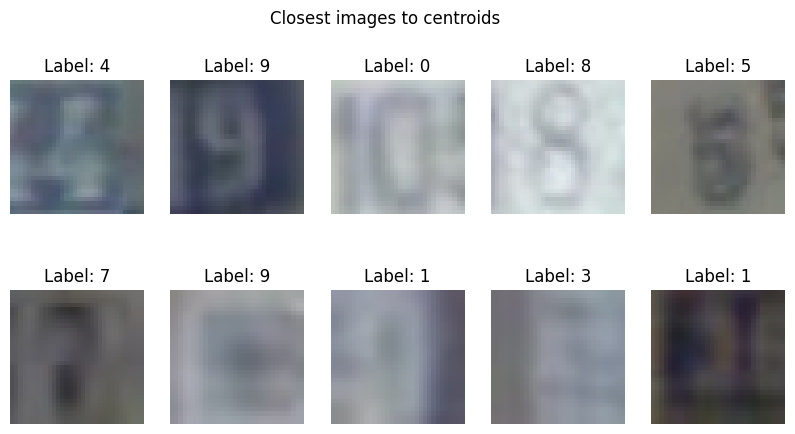

In [30]:
# Visualise point closest to each centroid
closest_idxs = closest_idxs.astype(int)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[closest_idxs[i]])
    ax.axis('off')
    ax.set_title(f'Label: {y_train[closest_idxs[i]]}')
plt.suptitle('Closest images to centroids')

In [31]:
# Print the labels in each cluster
for i in range(10):
    print(f'Cluster {i}: | {np.bincount(y_train[labels == i])}')

Cluster 0: | [247 234 226 228 275 237 249 225 297 218]
Cluster 1: | [313 297 312 322 298 338 312 333 311 369]
Cluster 2: | [250 217 250 230 234 237 228 234 202 212]
Cluster 3: | [128 136 135 132 115 107 131 104 121 112]
Cluster 4: | [381 352 374 381 365 389 379 419 377 402]
Cluster 5: | [374 382 378 383 400 392 379 342 401 368]
Cluster 6: | [348 306 291 281 324 309 305 302 306 322]
Cluster 7: | [178  88  94 106 116 104 151 134 154 124]
Cluster 8: | [ 22 186 159 127 107  95  74 100  75  83]
Cluster 9: | [259 302 281 310 266 292 292 307 256 290]


In [33]:
# Find centroids with PCA with 26 components
pca_26 = PCA(n_components=26)
pca_26.fit(X_train.reshape(-1, 32 * 32 * 3))
X_train_pca_26 = pca_26.transform(X_train.reshape(-1, 32 * 32 * 3))

centroids_pca_26, labels_pca_26, closest_idxs_pca_26, sse_26 = find_centroids(X_train_pca_26, scale=True)

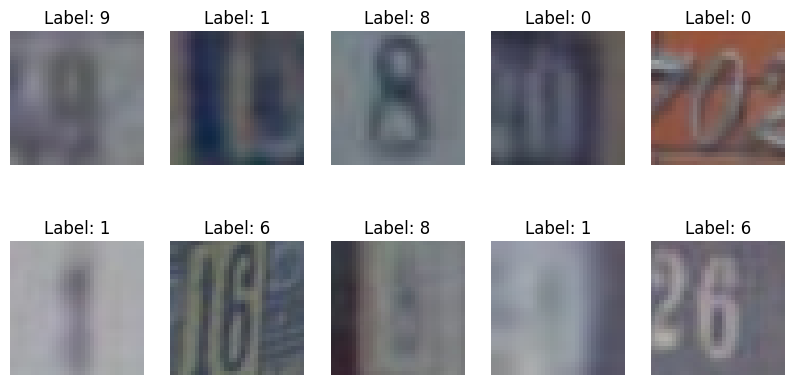

In [34]:
# visualise point closest to each pca centroid
closest_idxs_pca_26 = closest_idxs_pca_26.astype(int)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[closest_idxs_pca_26[i]])
    ax.axis('off')
    ax.set_title(f'Label: {y_train[closest_idxs_pca_26[i]]}')

In [35]:
# Print the labels in each cluster
for i in range(10):
    print(f'Cluster {i}: | {np.bincount(y_train[labels_pca_26 == i])}')

Cluster 0: | [351 123 169 173 181 205 228 265 202 276]
Cluster 1: | [ 68 679 145 131 709 102 115 298  99 111]
Cluster 2: | [ 75  20 189 292  52 407 312 187 392 171]
Cluster 3: | [338  48 192 317  31 348 344 121 319 290]
Cluster 4: | [ 81  88  83  84  83  90  97  76  87 102]
Cluster 5: | [389 514 531 373 548 316 301 489 247 323]
Cluster 6: | [587 531 653 624 538 559 555 614 577 594]
Cluster 7: | [ 39 314 270 233 187 150 111 167  93 125]
Cluster 8: | [290 110 155 152 155 161 212 237 220 228]
Cluster 9: | [282  73 113 121  16 162 225  46 264 280]


In [36]:
# Find centroids with PCA with 10 components
pca_10 = PCA(n_components=10)
pca_10.fit(X_train.reshape(-1, 32 * 32 * 3))
X_train_pca_10 = pca_10.transform(X_train.reshape(-1, 32 * 32 * 3))

centroids_pca_10, labels_pca_10, closest_idxs_pca_10, sse_10 = find_centroids(X_train_pca_10, scale=True)

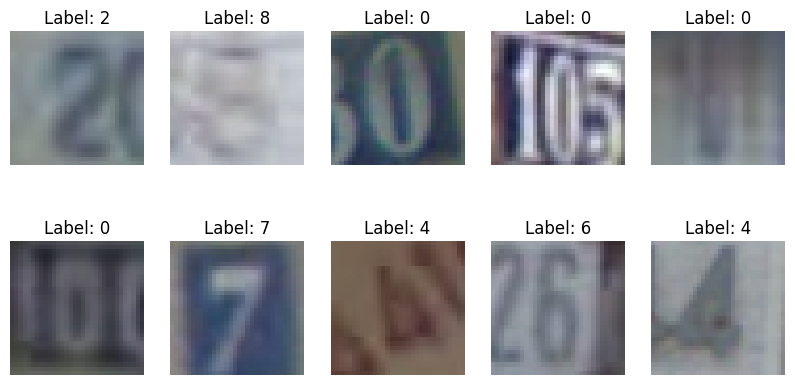

In [37]:
# visualise point closest to each pca centroid
closest_idxs_pca_10 = closest_idxs_pca_10.astype(int)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[closest_idxs_pca_10[i]])
    ax.axis('off')
    ax.set_title(f'Label: {y_train[closest_idxs_pca_10[i]]}')

In [38]:
# Print the labels in each cluster
for i in range(10):
    print(f'Cluster {i}: | {np.bincount(y_train[labels_pca_10 == i])}')

Cluster 0: | [174 374 425 466 437 351 228 299 267 354]
Cluster 1: | [277 209 235 221 178 227 217 176 225 216]
Cluster 2: | [386  78  67 153  75 241 385  14 328 292]
Cluster 3: | [ 27 271 256 226 175 160 117 143  94 123]
Cluster 4: | [138  91 116 126 110 119 101 255 129 164]
Cluster 5: | [486 415 529 495 428 516 451 432 494 501]
Cluster 6: | [159 445 292 228 297 171 134 501 123 128]
Cluster 7: | [261 252 251 239 247 257 248 229 263 229]
Cluster 8: | [292 107 155 169 170 201 244 221 229 223]
Cluster 9: | [300 258 174 177 383 257 375 230 348 270]


#### (b) Find the sum squared error for each of these different clustering obtained in 2(a). Make use of the label information associated with the images to evaluate your clustering. Specifically, evaluate the goodness of your clusters for various cases in 2(a) by using two evaluation metrics purity and rand-index.

In [39]:
# Print the sum squared error for each method
print(f'SSE for normal data: {sse}')
print(f'SSE for PCA with 26 components: {sse_26}')
print(f'SSE for PCA with 10 components: {sse_10}')

SSE for normal data: 31422759.65484619
SSE for PCA with 26 components: 565362.6659664314
SSE for PCA with 10 components: 172516.35019693797


In [40]:
# Purity: Number of correctly matched classes / Total number of samples
def purity(
    labels:np.ndarray,
    y:np.ndarray,
    n_classes:int=10
    ):
    """ Calculates the purity of the clusters
        params:
            labels: The labels assigned to each cluster
            y: The true labels of the data
        returns:
            The purity of the clusters
    """

    correct_preds = 0

    for i in range(n_classes):
        cluster_label = np.argmax(np.bincount(y[labels == i]))
        correct_preds += np.sum(y[labels == i] == cluster_label)

    return correct_preds / y.shape[0]

In [41]:
# Print purity for each method
print(f'Purity for normal data: {purity(labels, y_train)}')
print(f'Purity for PCA with 26 components: {purity(labels_pca_26, y_train)}')
print(f'Purity for PCA with 10 components: {purity(labels_pca_10, y_train)}')

Purity for normal data: 0.11576
Purity for PCA with 26 components: 0.16016
Purity for PCA with 10 components: 0.14492


In [42]:
# Print rand index for each method

from sklearn.metrics import rand_score

print(f'Rand index for normal data: {rand_score(labels, y_train)}')
print(f'Rand index for PCA with 26 components: {rand_score(labels_pca_26, y_train)}')
print(f'Rand index for PCA with 10 components: {rand_score(labels_pca_10, y_train)}')

Rand index for normal data: 0.8075937085483419
Rand index for PCA with 26 components: 0.8004677531101244
Rand index for PCA with 10 components: 0.8108739869594784
